<a href="https://colab.research.google.com/github/fadillarizalul/thesis-alzheimer/blob/main/thesis_model_mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# set up dan init

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

In [2]:
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

In [3]:
import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns

#import data dari drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!wget --no-check-certificate \
https://github.com/fadillarizalul/thesis-alzheimer/blob/main/dataset/3-classes-alzheimer-20-patients.zip?raw=true \
  -O 3-classes-alzheimer.zip

--2022-09-17 15:49:11--  https://github.com/fadillarizalul/thesis-alzheimer/blob/main/dataset/3-classes-alzheimer-20-patients.zip?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/fadillarizalul/thesis-alzheimer/raw/main/dataset/3-classes-alzheimer-20-patients.zip [following]
--2022-09-17 15:49:11--  https://github.com/fadillarizalul/thesis-alzheimer/raw/main/dataset/3-classes-alzheimer-20-patients.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fadillarizalul/thesis-alzheimer/main/dataset/3-classes-alzheimer-20-patients.zip [following]
--2022-09-17 15:49:12--  https://raw.githubusercontent.com/fadillarizalul/thesis-alzheimer/main/dataset/3-classes-alzheimer-20-patients.zip
Resolving raw.githubusercontent.com (raw.githubusercontent

In [6]:
!unzip /content/3-classes-alzheimer.zip

Archive:  /content/3-classes-alzheimer.zip
   creating: 3-classes-alzheimer-20-patients/
   creating: 3-classes-alzheimer-20-patients/AD/
  inflating: 3-classes-alzheimer-20-patients/AD/img-00001-00001.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00001-00002.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00001-00003.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00001-00004.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00001-00005.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00002-00001.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00002-00002.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00002-00003.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00002-00004.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00002-00005.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00003-00001.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00003-00002.jpg  
  inflating: 3-classes

In [7]:
import os
 #lokasi direktori dasar
dir_base ='/content/3-classes-alzheimer-20-patients'
os.listdir(dir_base)
print(os.listdir(dir_base))

#hitung jumlah file per direktori
data_cn = len(os.listdir('/content/3-classes-alzheimer-20-patients/CN'))
data_mci = len(os.listdir('/content/3-classes-alzheimer-20-patients/MCI')) 
data_ad = len(os.listdir('/content/3-classes-alzheimer-20-patients/AD')) 

print("Amount of CN class images:", data_cn)
print("Amount of MCI class images:", data_mci)
print("Amount of AD class images:", data_ad)

['MCI', 'AD', 'CN']
Amount of CN class images: 101
Amount of MCI class images: 100
Amount of AD class images: 108


In [8]:
BATCH_SIZE = 32
IMG_SHAPE = 256

## Split into train, test, and validation sets

In [9]:
# from sklearn.model_selection import train_test_split
# from keras_preprocessing.image import ImageDataGenerator

# # First split into train and test sets at 80:20 ratio
# # Second split into train validation at 75:25 ratio
# # - results in 60:20:20 ratio (train, val, test)
# train, test = train_test_split(dir_base, test_size=0.2, random_state=1)
# train, val = train_test_split(train, test_size=0.25, random_state=1)

# Data Generation and Augmentation

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  # rotation_range=30,
                                  # zoom_range=0.2,
                                  # horizontal_flip=True,
                                  # vertical_flip=True,
                                   validation_split = 0.2
                                   )

valid_datagen = ImageDataGenerator(rescale = 1./255
#                                    validation_split = 0.2
                                  )

# test_datagen  = ImageDataGenerator(rescale = 1./255)

In [13]:
train_generator = train_datagen.flow_from_directory(
    directory = dir_base,
    target_size = (IMG_SHAPE,IMG_SHAPE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    subset='training'
)
 
val_generator = train_datagen.flow_from_directory(
    directory = dir_base,
    target_size = (IMG_SHAPE,IMG_SHAPE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    subset='validation'
)

Found 248 images belonging to 3 classes.
Found 61 images belonging to 3 classes.


In [14]:
# # TRAIN
# image_gen_train = ImageDataGenerator(rescale=1./255., 
#                                      horizontal_flip=True, 
#                                      rotation_range=20, 
#                                      zoom_range=0.2)

# train_generator = image_gen_train.flow_from_directory(
#     train,
#     directory = dir_base,
#     target_size = (IMG_SHAPE,IMG_SHAPE),
#     batch_size = BATCH_SIZE,
#     class_mode = 'categorical'
# )

In [15]:
# # VALID
# image_gen_val = ImageDataGenerator(rescale=1./255.)

# val_generator = image_gen_val.flow_from_directory(
#     val,
#     directory = dir_base,
#     target_size = (IMG_SHAPE,IMG_SHAPE),
#     batch_size = BATCH_SIZE,
#     class_mode = 'categorical'
# )

In [16]:
# # TEST
# image_gen_test = ImageDataGenerator(rescale=1./255.)

# test_generator = image_gen_val.flow_from_directory(
#     test,
#     directory = dir_base,
#     target_size = (IMG_SHAPE,IMG_SHAPE),
#     batch_size = BATCH_SIZE,
#     class_mode = 'categorical'
# )

# Create CNN model

In [17]:
from tensorflow.keras.applications import MobileNetV2
# get base models
base_model = MobileNetV2(
    input_shape=(IMG_SHAPE,IMG_SHAPE,3),
    include_top=False,
    weights='imagenet',
    classes=3,
)

from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model

num_class = 3

#Adding custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation="relu")(x)
predictions = layers.Dense(num_class, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

9420800/9406464 [==============================] - 0s 0us/step


In [20]:
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152V2

classes = 3

model = tf.keras.models.Sequential([
    MobileNetV2(include_top=False, weights='imagenet', classes=classes, input_tensor=Input(shape=(150, 150, 3))),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.layers[0].trainable = False
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_9 (Dense)             (None, 512)               524800    
                                                                 
 dense_10 (Dense)            (None, 3)                

# Compile the Model

In [21]:
from tensorflow.keras.optimizers import RMSprop
# compile model dengan 'adam' optimizer loss function 'categorical_crossentropy' 
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

early stopping

In [22]:
#callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>0.95):
      print("\n akurasi telah mencapai >95%!")
      self.model.stop_training = True
callbacks = myCallback()

In [25]:
# latih model dengan model.fit 
history = model.fit(
      train_generator,
      #steps_per_epoch=12,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs= 30, # tambahkan eposchs jika akurasi model belum optimal
      validation_data=val_generator, # menampilkan akurasi pengujian data validasi
      #validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2,
      callbacks=[callbacks]
      )

Epoch 1/30
8/8 - 11s - loss: 1.0841 - accuracy: 0.5323 - val_loss: 1.2286 - val_accuracy: 0.3607 - 11s/epoch - 1s/step
Epoch 2/30
8/8 - 11s - loss: 1.0137 - accuracy: 0.4516 - val_loss: 1.1752 - val_accuracy: 0.3279 - 11s/epoch - 1s/step
Epoch 3/30
8/8 - 11s - loss: 0.8919 - accuracy: 0.5323 - val_loss: 1.5200 - val_accuracy: 0.3279 - 11s/epoch - 1s/step
Epoch 4/30
8/8 - 11s - loss: 0.8927 - accuracy: 0.5363 - val_loss: 1.3002 - val_accuracy: 0.2951 - 11s/epoch - 1s/step
Epoch 5/30
8/8 - 11s - loss: 0.8013 - accuracy: 0.6613 - val_loss: 1.3320 - val_accuracy: 0.3115 - 11s/epoch - 1s/step
Epoch 6/30
8/8 - 11s - loss: 0.7093 - accuracy: 0.6815 - val_loss: 1.4910 - val_accuracy: 0.2623 - 11s/epoch - 1s/step
Epoch 7/30
8/8 - 10s - loss: 0.6104 - accuracy: 0.7419 - val_loss: 1.7244 - val_accuracy: 0.2623 - 10s/epoch - 1s/step
Epoch 8/30
8/8 - 11s - loss: 0.6827 - accuracy: 0.6935 - val_loss: 2.0867 - val_accuracy: 0.3115 - 11s/epoch - 1s/step
Epoch 9/30
8/8 - 11s - loss: 0.6269 - accuracy: 

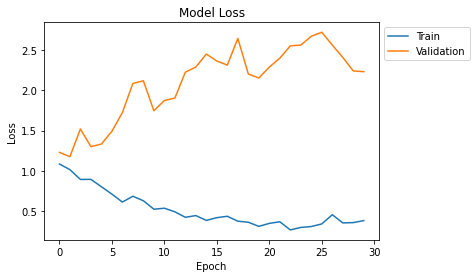

In [26]:
# Summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

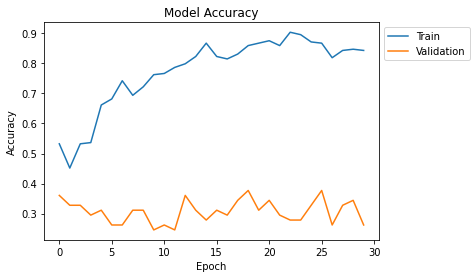

In [27]:
# Summarize history for loss

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()